In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from statannotations.Annotator import Annotator
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Vegan vs Omnivore diet dataset


In [2]:
#import dataframes

#import MZmine feature table
ftable_mzmine = pd.read_csv('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/PlantMASST/Examples paper/NIST_diet_vegetarian_omnivore_MSV000086989/ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-b586c401-view_all_annotations_DB/quantification_table/quantification_table_formated.txt', sep='\t', index_col=0)
#import the combined plantmasst table
plantmasst = pd.read_csv('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/PlantMASST/Examples paper/NIST_diet_vegetarian_omnivore_MSV000086989/fastMASST_Mar2024_all_features.nosync/combined_tables/DietNIST_analog_off_combined_tables/DietNIST_plant.tsv', sep='\t')
#import the metadata of the study
metadata = pd.read_csv('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/PlantMASST/Examples paper/NIST_diet_vegetarian_omnivore_MSV000086989/metadata.txt', sep='\t')


In [3]:
#define a function to process and analyze the dataset

def preprocess_and_analyze_abundance(ftable_mzmine, plantmasst, metadata):
    # Filter out specified rows from plantmasst
    plantmasst_filtered = plantmasst[(plantmasst.Blank != 'Yes') & 
                                             (plantmasst.QC != 'Yes') & 
                                             (plantmasst.MassIVE != 'MSV000083756')]

    # Compare the row IDs with the scan numbers that had matches and add new columns
    new_columns = {}
    for column in ftable_mzmine.columns:
        column_name_temp = column + '_plantmasst'  # Add suffix
        new_column = pd.Series(0, index=ftable_mzmine.index)  # Initialize the new column with zeros
        # Assign the value from ftable_mzmine where there's a match
        new_column[(ftable_mzmine[column] != 0) & 
                   (ftable_mzmine.index.isin(plantmasst_filtered['Scan']))] = ftable_mzmine[column]
        new_columns[column_name_temp] = new_column  # Add new columns to the dictionary

    ftable_mzmine = pd.concat([ftable_mzmine, pd.DataFrame(new_columns)], axis=1)

    # Calculate sum of each column to get the number of the total area of the features
    sums = ftable_mzmine.sum(axis=0)
    summed_df = pd.DataFrame({'filename': sums.index, 'total_features': sums.values})

    # Create a new column 'plantmasst_features' by summing columns with '_plantmasst' suffix
    summed_df['plantmasst_features'] = summed_df['filename'].apply(
        lambda x: summed_df.loc[summed_df['filename'] == x + '_plantmasst', 'total_features'].sum())

    # Drop rows with the original column names (without '_plantmasst')
    summed_df = summed_df[~summed_df['filename'].str.contains('_plantmasst')]

    # Reset the index
    summed_df = summed_df.reset_index(drop=True)

    # Calculate the percentage of the total features that had a match with plantmasst
    summed_df['percentage'] = summed_df['plantmasst_features'] / summed_df['total_features'] * 100

    # Merge with metadata and reorganize
    summed_df_merged = pd.merge(summed_df, metadata, on='filename', how='left')

    return summed_df_merged

#apply the function
summed_df_merged = preprocess_and_analyze_abundance(ftable_mzmine, plantmasst, metadata)

#Rename groups
summed_df_merged['diet'] = summed_df_merged['diet'].str.replace('omnivore', 'Omnivore')
summed_df_merged['diet'] = summed_df_merged['diet'].str.replace('vegetarian', 'Vegan')

#put in the desired order
order = ['Omnivore', 'Vegan']

summed_df_merged['diet'] = pd.Categorical(summed_df_merged['diet'], categories=order, ordered=True)
summed_df_merged = summed_df_merged.sort_values('diet')


Omnivore vs. Vegan: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.031e-10 U_stat=0.000e+00


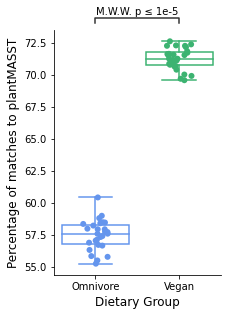

In [4]:
#Plot boxplots

plt.figure(figsize=(3, 4.5))

my_pal = {'Vegan': 'mediumseagreen', 'Omnivore': 'cornflowerblue'}

# Create boxplot and stripplot
ax = sns.boxplot(x='diet', y='percentage', data=summed_df_merged, notch=False, 
                 palette={'Vegan': 'white', 'Omnivore': 'white'})

# Add colored dots for each category
for diet in summed_df_merged['diet'].unique():
    sns.stripplot(
        x='diet', 
        y='percentage', 
        data=summed_df_merged[summed_df_merged['diet'] == diet], 
        color=my_pal[diet], 
        jitter=0.15, 
        size=6,
        ax=ax
    )

# Define pairs for statistical comparison
pairs = [("Omnivore", "Vegan")]

# Initialize the Annotator with the defined pairs, data, and axis configuration
annotator = Annotator(ax, pairs, data=summed_df_merged, x='diet', y='percentage')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside', comparisons_correction='Bonferroni')

# Change the axis titles here
plt.xlabel('Dietary Group', size=12)  # Change the X-axis title
plt.ylabel('Percentage of matches to plantMASST', size = 12)     # Change the Y-axis title

for i, artist in enumerate(ax.artists):
    artist.set_edgecolor(my_pal[summed_df_merged['diet'].unique()[i]])
    # Each patch has 6 associated Line2D objects (the whiskers, the caps, and the median)
    for j in range(i*6, i*6+6):
        line = ax.lines[j]
        line.set_color(my_pal[summed_df_merged['diet'].unique()[i]])
        line.set_mfc(my_pal[summed_df_merged['diet'].unique()[i]])
        line.set_mec(my_pal[summed_df_merged['diet'].unique()[i]])

# Hide the top and right spines
sns.despine()

# Customization for the lines: only leave the bottom and left spines
ax = plt.gca()  # Get the current Axes instance
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Apply and annotate statistical tests
annotator.apply_and_annotate()

# plt.savefig('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/PlantMASST/Figures/Figure 2/Vegan_vs_Omnivore.pdf')
plt.show()